# 01 Import Libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import importlib

In [5]:
!rm -r Learning-the-Optimal-Solution-Path
!git clone https://github.com/Cumberkid/Learning-the-Optimal-Solution-Path.git

rm: cannot remove 'Learning-the-Optimal-Solution-Path': No such file or directory
Cloning into 'Learning-the-Optimal-Solution-Path'...
remote: Enumerating objects: 1704, done.
remote: Counting objects: 100% (674/674), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 1704 (delta 511), reused 479 (delta 359), pack-reused 1030
Receiving objects: 100% (1704/1704), 13.24 MiB | 10.38 MiB/s, done.
Resolving deltas: 100% (1148/1148), done.


In [6]:
import sys

In [7]:
# Add the parent directory to sys.path
sys.path.append('/content/Learning-the-Optimal-Solution-Path')

In [8]:
import lib
importlib.reload(lib)

<module 'lib' from '/content/Learning-the-Optimal-Solution-Path/lib/__init__.py'>

In [9]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.ngs.loss_fn import reg_exp_weighted_logit
from lib.ngs.log_reg_module import Logistic_Regression
from lib.ngs.reg_solver import train, test

# 02 Instantiate Variables




In [10]:
# file path for Colab. May need to change this
X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')

In [11]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [12]:
X_tune = X[:200, :]
y_tune = y[:200]

In [13]:
train_X = torch.tensor(X_tune, dtype=torch.float32)
train_y = torch.tensor(y_tune, dtype=torch.float32)

In [14]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=20, shuffle=True, )
# test data
test_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=False, )

In [15]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]

In [16]:
loss_fn = reg_exp_weighted_logit

In [17]:
lr_list = 0.5 ** np.arange(-2, 11)
beta_list = 0.5 ** np.arange(-4, 11)

# 03 Define Functions

In [18]:
def gen_loss_gd(lam, lr):

    weight = torch.zeros(input_dim)
    intercept = 0
    model = Logistic_Regression(input_dim, 1, lam, weight, intercept).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    itr = 0
    for t in range(100):
        itr, weight, intercept = train(itr, weight, intercept, GD_data_loader,
                                       model, loss_fn, optimizer, device)

    loss = test(test_data_loader, model, loss_fn, lam, device)

    return loss

In [19]:
def step_size(t, beta):
    return beta/np.sqrt(t+1)

In [20]:
def gen_loss_sgd(lam, beta):

    weight = torch.ones(input_dim)
    intercept = 1
    model = Logistic_Regression(input_dim, 1, lam, weight, intercept).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    itr = 0
    for t in range(100):
        itr, weight, intercept = train(itr, weight, intercept, SGD_data_loader, model,
                                       loss_fn, optimizer, True, step_size, beta, device)

    with torch.no_grad():
        model.linear.weight.copy_(weight)
        model.linear.bias.copy_(intercept)
    loss = test(test_data_loader, model, loss_fn, lam, device)

    return loss

# 04 Tuning lr for exact gradient descent

Pick lr = 1

In [21]:
lam = 7

In [22]:
losses = []
for lr in lr_list:
    loss = gen_loss_gd(lam, lr)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 4.0	 loss: 1.0060943365097046
learning rate: 2.0	 loss: 0.18644055724143982
learning rate: 1.0	 loss: 0.15865491330623627
learning rate: 0.5	 loss: 0.15865492820739746
learning rate: 0.25	 loss: 0.15865491330623627
learning rate: 0.125	 loss: 0.1586623340845108
learning rate: 0.0625	 loss: 0.15898385643959045
learning rate: 0.03125	 loss: 0.16096718609333038
learning rate: 0.015625	 loss: 0.16518287360668182
learning rate: 0.0078125	 loss: 0.17033779621124268
learning rate: 0.00390625	 loss: 0.17640429735183716
learning rate: 0.001953125	 loss: 0.18513649702072144
learning rate: 0.0009765625	 loss: 0.19665467739105225


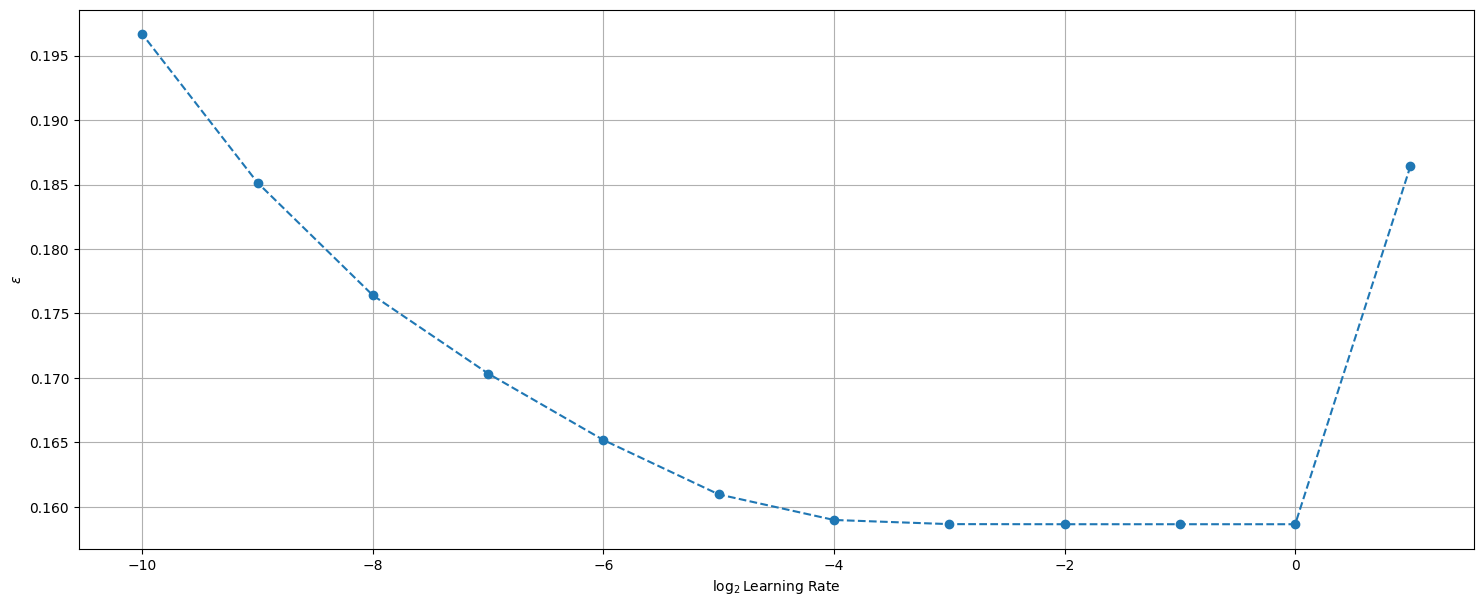

In [23]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(lr_list[1:]), losses[1:], '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)

# 05 Tuning $\beta$ for noisy gradient descent where lr = $\beta/\sqrt{t}$

Pick $\beta = 0.5$

In [24]:
lam = 7

In [25]:
losses = []
for beta in beta_list:
    loss = gen_loss_sgd(lam, beta)

    print(f"beta: {beta}\t loss: {loss}")
    losses.append(loss)

beta: 16.0	 loss: 0.5328788757324219
beta: 8.0	 loss: 0.2504085600376129
beta: 4.0	 loss: 0.17107632756233215
beta: 2.0	 loss: 0.16011294722557068
beta: 1.0	 loss: 0.158916175365448
beta: 0.5	 loss: 0.15890182554721832
beta: 0.25	 loss: 0.1748071014881134
beta: 0.125	 loss: 0.4233188033103943
beta: 0.0625	 loss: 1.3823343515396118
beta: 0.03125	 loss: 2.8616576194763184
beta: 0.015625	 loss: 4.177113056182861
beta: 0.0078125	 loss: 5.056379318237305
beta: 0.00390625	 loss: 5.565792083740234
beta: 0.001953125	 loss: 5.839874744415283
beta: 0.0009765625	 loss: 5.982144832611084


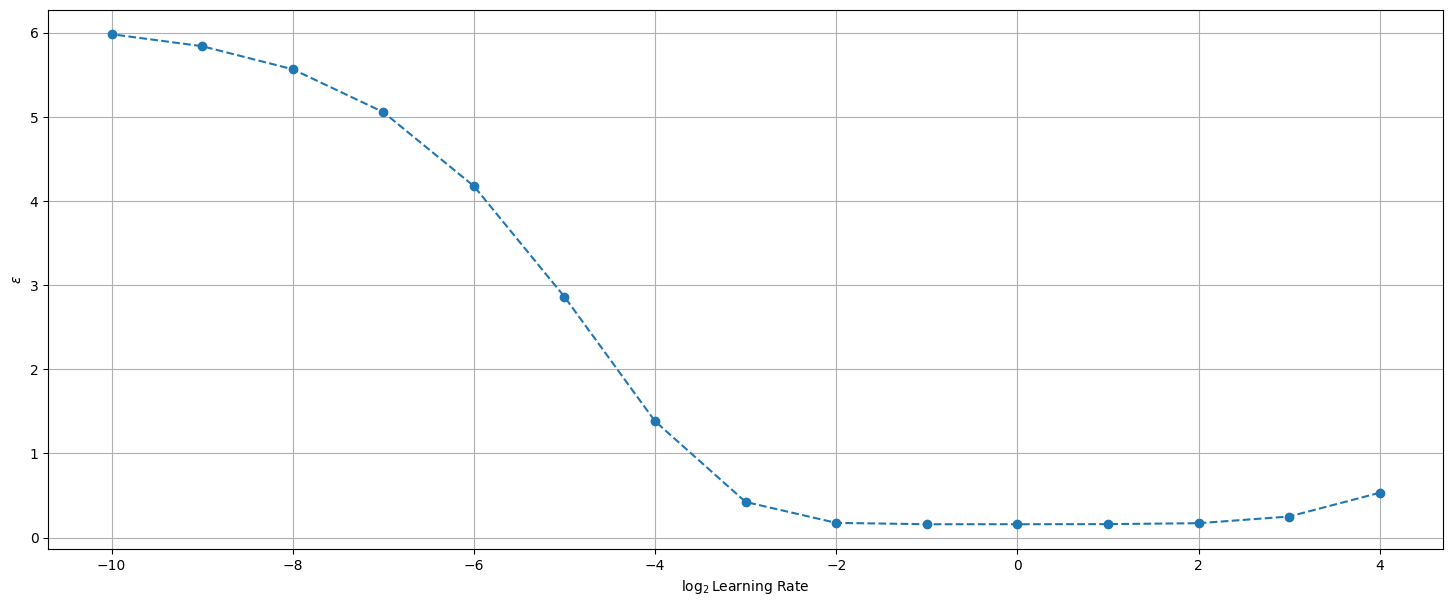

In [26]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(np.log2(beta_list), losses, '--o')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.grid(True)